In [23]:
import csv
import pandas as pd
import requests
import urllib.request
from IPython.display import Image
import spacy
from PIL import Image, ImageDraw, ImageFont
!pip install -U stanza
import stanza
import string
from os import listdir
import matplotlib.pyplot as plt
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from PIL import ImageTk,ImageDraw,ImageFont
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from google.colab import drive
drive.mount("/content/drive")

#stanza.download('it')
nlp=stanza.Pipeline('it',processors='tokenize,mwt,pos,lemma',tokenize_pretokenized=True)

def try_synset(lemmax):
  global synsetFound
  
  synsetsList=[]
  for synset in wn.synsets(lemmax,lang=('ita')):
      for lemma in synset.lemma_names(u'ita'):
          if(lemmax!=lemma):
            synsetsList.append(lemma)
  for i in range(len(synsetsList)):
    response = requests.get("https://api.arasaac.org/api/pictograms/it/search/" + synsetsList[i])
    status = response.status_code
    if status == 200:
      synsetFound=True
      j = response.json()
      id = j[0]['_id']
      return id

"""def text_on_img(filename, text, size):
    size=60
    fnt = ImageFont.truetype('/content/drive/MyDrive/arial.ttf', size)
    w,h = fnt.getsize(text)
    W=int(size/1.5)*len(text)
    H=size+50
    im = PIL.Image.new(mode="RGB", size = (int(size/1.5)*len(text),size+50),color="white")
    #fnt = ImageFont.load_default()
    

    draw = ImageDraw.Draw(im)
    # draw text
    draw.text(((W-w)/2,(H-h)/3), text, font=fnt, fill=(0,0,0))
    im.save(path_CAA_pictograms+filename)"""

def text_on_img(filename, text, size):
    
    if(len(text)<5):
      fnt = ImageFont.truetype('/content/drive/MyDrive/arial.ttf', size)
    else:
      size=size-20
      fnt = ImageFont.truetype('/content/drive/MyDrive/arial.ttf', size)
    W, H = (280,280)
    # create image
    image = PIL.Image.new(mode = "RGB", size = (W,H), color = "white")
    draw = ImageDraw.Draw(image)
    w, h = draw.textsize(text,font=fnt)
    # draw text
    draw.text((((W-w)/2,(H-h)/3)), text,font=fnt, fill=(0,0,0))
    # save file
    image.save(path_CAA_pictograms+filename)

def getInfo(word):
    global synsetFound
    synsetFound=False
    global index
    global imageName

    type=word[1]
    if(type!='PROPN'):
      token=word[0].lower()
      lemma=word[2].lower()
    else:
      token = word[0]
      lemma=word[2]
    gender=""
    """if(type=='DET'):
      lemma=token"""
    if(type=='NOUN'):
      lemma=token
    if(type=='NOUN' or type=='DET' or type=='PRON' or type=='ADJ'):
      if(word[3]!=None):

        splitted=word[3].split("|")
        for i in range(len(splitted)):
            if splitted[i].find("Gender")!=-1:
              gender=splitted[i].split("=")[1]
        if(gender=="Fem" and gender!=""):
          lemma=token
    #lemma=word[2]
    action = 'indef'
    result = []

    #identify if the word is a verb or auxiliar    
    if (type == 'AUX'):
        
        tense=word[3].split("|")[3].split("=")[1]
        
        if(tense=="Past" or tense=="Imp"):
          action="past"
        if(tense=="Fut"):
          action='future'
    
    if (type == 'VERB'):
        if not word[3].split("=")[1]=="Inf":
              
            tense=word[3].split("|")[2].split("=")[1]
            
            if(tense=="Past" or tense=="Imp"):
              action="past"
            if(tense=="Fut"):
              action='future'
    
    result.append(lemma) #add to the list the token  #TOKENCAA [0]
    result.append(action) #add to the list the action   #ACTION [1]

    number="sing"
    if(type!='ADP' and type!='ADV' and type!='INTJ' and type!='PUNCT' and type!='CCONJ' and type!='PROPN' and type!='SCONJ' and type!='X'):
      if(word[3]!=None):
          
        plural=word[3].split("|")
        
        for i in range(len(plural)):
            if plural[i].find("Number")!=-1:
              number=plural[i].split("=")[1]
              
    result.append(number)
    response = requests.get("https://api.arasaac.org/api/pictograms/it/search/" + lemma) #Obtain best pictograms based on the searchText
    status = response.status_code
    if status == 200:

      j = response.json()
      keywords=[]
      for word2 in j:
          try:
            keyword=word2["keywords"][0]["keyword"]
            if(len(keyword)>=len(token)):
              if(len(keyword)>3):
                keywords.append(keyword)
            if(len(keywords)==10):
              break
          except:
            print("Something went wrong")
      if(len(keywords)>0):
        """if(keywords[0]!=token):
          keywords=[]"""
        keywords=[s for s in keywords if s != lemma and s != word[2] ]
        present=False
        for keyword in keywords:
            
            if lemma_sentence.find(keyword)!=-1:
                present=True
                words=len(keyword.split(" "))
                print(words,": ",keyword)
                global index
                index+=words
                global words_for_images
                words_for_images.append(keyword)
                response2 = requests.get("https://api.arasaac.org/api/pictograms/it/bestsearch/" + keyword)
                j2=response2.json()
                id = j2[0]['_id']
                result.append(id)
                index+=1
                return result
                break
    
    response = requests.get("https://api.arasaac.org/api/pictograms/it/bestsearch/" + lemma)
    j = response.json()
    status = response.status_code
    if status == 200:
      
      id = j[0]['_id'] #extract id by response
      result.append(id) #add to the list the id #ID [2]
      
      words_for_images.append(token)
      
      return result
    elif status == 404:
      print('404-no pictogram associated with this word exists =', lemma)
      id=try_synset(lemma)
      if(synsetFound==True):
        result.append(id)
        words_for_images.append(token)
        return result
      else:
        print("No synset found")
        #print('saving img n: ',index)
        if(type=='VERB' or type=='AUX'):
          text_on_img(filename=str(imageName)+".png",text=token, size=70)
          words_for_images.append(token)
          index_list.append(index)
        else:
          text_on_img(filename=str(imageName)+".png",text=lemma, size=70)
          words_for_images.append(lemma)
          index_list.append(index)
        index+=1
        imageName+=1
        
        return result
    elif status == 400:
      print('400-no pictogram associated with this word exists =', lemma)
      #print('saving img n: ',index)
      if(type=='VERB' or type=='AUX'):
        text_on_img(filename=str(imageName)+".png",text=token, size=100)
        words_for_images.append(token)
        index_list.append(index)
      else:
        text_on_img(filename=str(imageName)+".png",text=lemma, size=100)
        words_for_images.append(lemma)
        index_list.append(index)
      index+=1
      imageName+=1
      
      return result
    elif status == 500:
      print('500 status')
      index+=1
      words_for_images.append(lemma)
      
      return result
    
path_CAA_pictograms = "/content/drive/MyDrive/immagini/"

def getArray_id(words):
  array_id = []
  infos=[]
  global pics
  pics=[]
  global index
  while index<len(words):
    info = getInfo(words[index]) #TOKENCAA [0] | ACTION [1] | PLURAL_STATUS[2] | ID[3]
    #print("info:",info)
    if(len(info)==4):
      pics.append(info[3])
    infos.append(info)
    if(len(info)==4):

      action = info[1]
      id = info[3]
      plural_status = info[2]
      array_id.append(id) #add id to array_id
      getImg(id, plural_status,action) #save img
  
  return infos

def getImg(id, plural_status,action): #parameter:id, plural_status, action
  #print('id','id')
  global imageName
  global index
  global index_list
  if plural_status=="Plur":
    #Copy a network object denoted by a URL to a local file
    urllib.request.urlretrieve('https://static.arasaac.org/pictograms/'+str(id)+'/'+str(id)+'_plural_300.png',
   path_CAA_pictograms+str(imageName)+'.png')
    #print('saving img n: ',index)
    index_list.append(index)
    index+=1
    imageName+=1
    
  elif not action == 'indef':
    #Copy a network object denoted by a URL to a local file
    urllib.request.urlretrieve('https://static.arasaac.org/pictograms/'+str(id)+'/'+str(id)+'_action-'+action+'_300.png',
   path_CAA_pictograms +str(imageName)+'.png')
    #print('saving img n: ',index)
    index_list.append(index)
    index+=1
    imageName+=1
    
  else:
     #Copy a network object denoted by a URL to a local file
    urllib.request.urlretrieve('https://static.arasaac.org/pictograms/'+str(id)+'/'+str(id)+'_300.png',
   path_CAA_pictograms+str(imageName)+'.png')
    #print('saving img n: ',index)
    index_list.append(index)
    index+=1
    imageName+=1

def translate(input_text):
  global imageName
  global words_for_images_list
  global picsList
  global index
  index=0
  global index_list
  index_list=[]
  global lemma_sentence
  lemma_sentence=""
  global words_for_images
  words_for_images=[]
  frase=str(input_text)
  #print(frase)
  frase=re.sub(r"[-()\"#/@;:<>{}`+=~|$%&]", "", frase)
  frase=frase.replace("'","' ")
  frase=frase.replace("?"," ?")
  frase=frase.replace("!"," !")
  #frase= input()
  #words_for_images=[]

  """import glob
  fileList = glob.glob('/content/drive/MyDrive/immagini/*.png')
  for filePath in fileList:
    os.remove(filePath)"""

  doc=nlp(frase)
  #index=0
  lemmas=[]
  for sentence in doc.sentences:
      posT=[(w.text, w.pos,w.lemma,w.feats) for w in sentence.words]
      #print(posT)
      for i in posT:
        lemmas.append(i[2])
      lemma_sentence=""
      for i in lemmas:
        lemma_sentence+=i
        lemma_sentence+=" "
      getArray_id(posT)

      print('words for images: ',words_for_images)
      print('pics: ',pics)
      picsList.append(pics)
      words_for_images_list.append(words_for_images)
                      
      #plt.show()
      return(pics)

imageName=0
index=0
lemma_sentence=""
words_for_images=[]
pics=[]
picsList=[]
words_for_images_list=[]


#translate("Gioco in un campo da tennis")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:stanza:Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


words for images:  ['il', 'dono', 'del', 'Natale']
pics:  [8476, 3149, 11712, 3134]
404-no pictogram associated with this word exists = annunciare
words for images:  ['molto', 'tempo', 'fa', 'in', 'un', 'luogo', 'lontano', 'un', 'angelo', 'annunciò', 'a', 'Maria', 'che', 'avrebbe', 'partorito']
pics:  [5521, 22631, 28205, 7034, 2627, 9819, 30385, 2627, 3056, 11163, 3021, 7301, 11351, 7271, 31706]
2 :  avere paura
words for images:  ['Maria', 'era', 'spaventata', 'ma', "l'", 'angelo', 'le', 'disse', 'di', 'non', 'avere', 'avere paura']
pics:  [7301, 5465, 8979, 11377, 8476, 3056, 6481, 9693, 7074, 5525, 7271, 35571]
404-no pictogram associated with this word exists = partire
404-no pictogram associated with this word exists = betlemme
No synset found
words for images:  ['Maria', 'e', 'Giuseppe', 'partirono', 'per', 'betlemme']
pics:  [7301, 3026, 7238, 21328, 7194]
404-no pictogram associated with this word exists = betlemme
No synset found
words for images:  ['molte', 'persone', 'andav

,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

il


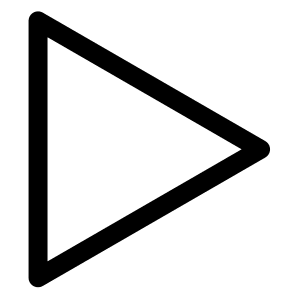

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dono


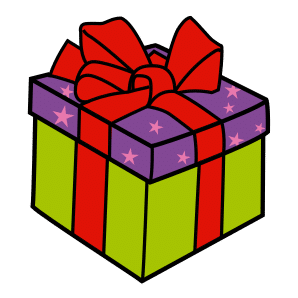

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

del


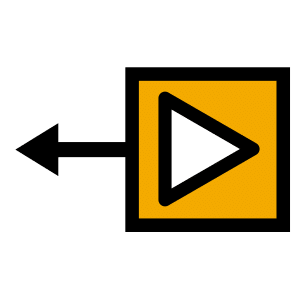

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Natale


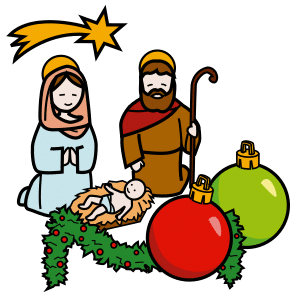

<IPython.core.display.Javascript object>

,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

molto


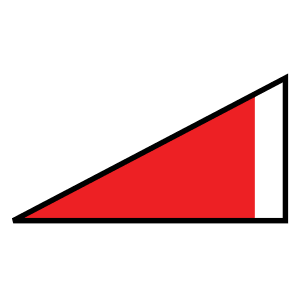

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tempo


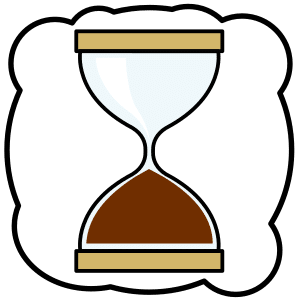

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

fa


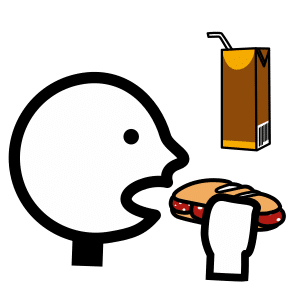

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

in


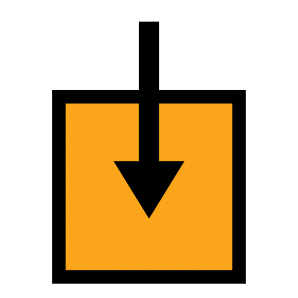

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

un


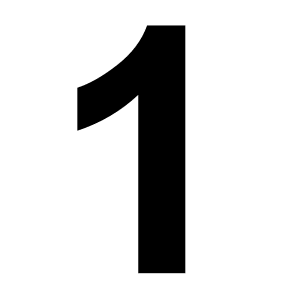

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

luogo


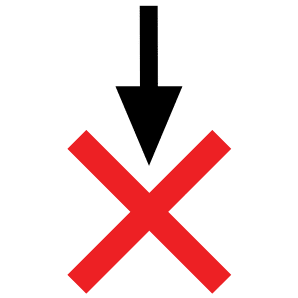

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

lontano


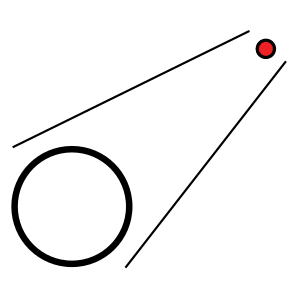

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

un


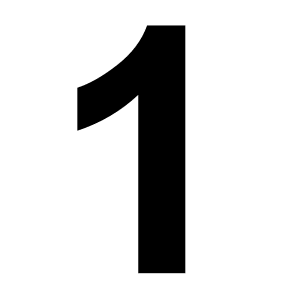

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

angelo


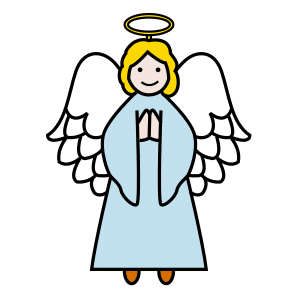

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

annunciò


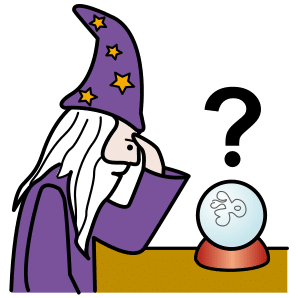

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

a


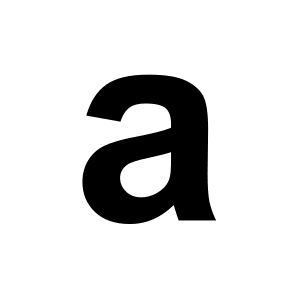

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Maria


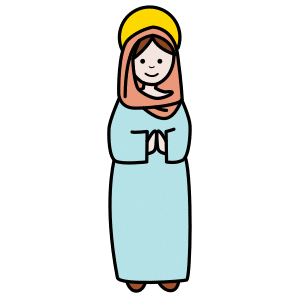

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

che


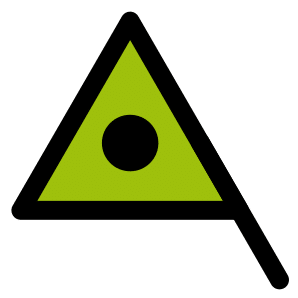

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

avrebbe


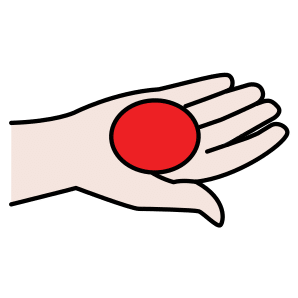

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

partorito


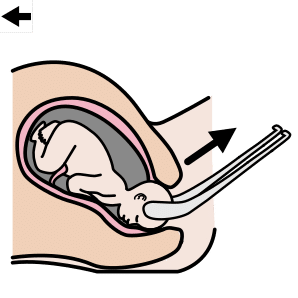

<IPython.core.display.Javascript object>

,,,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Maria


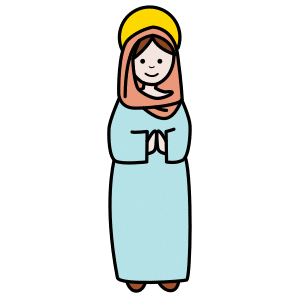

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

era


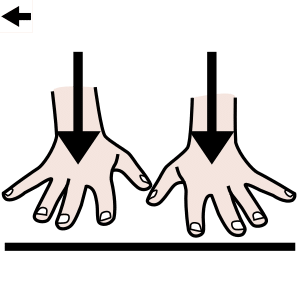

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

spaventata


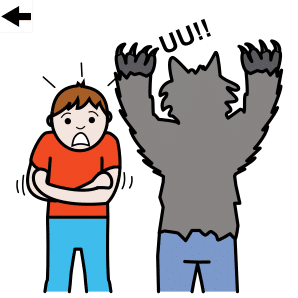

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ma


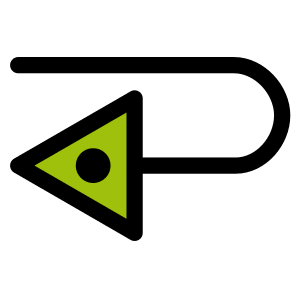

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

l'


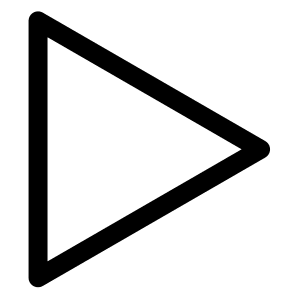

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

angelo


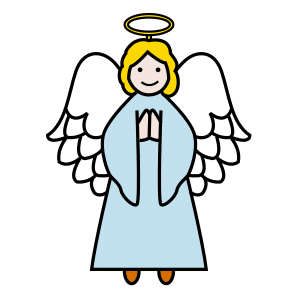

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

le


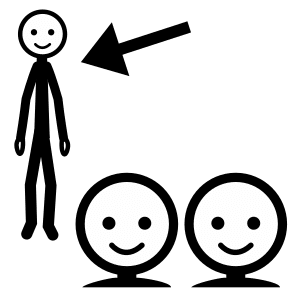

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disse


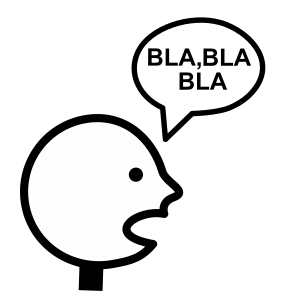

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

di


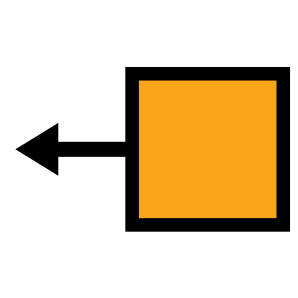

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

non


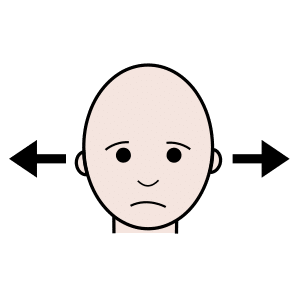

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

avere


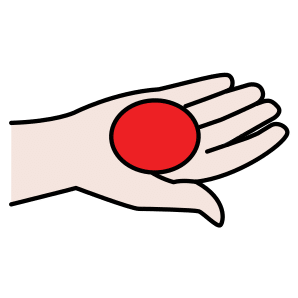

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

avere paura


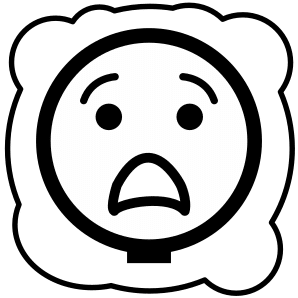

<IPython.core.display.Javascript object>

,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Maria


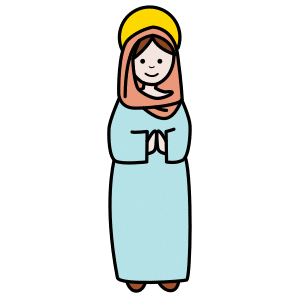

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e


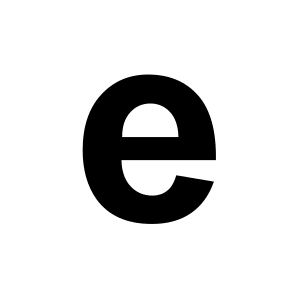

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Giuseppe


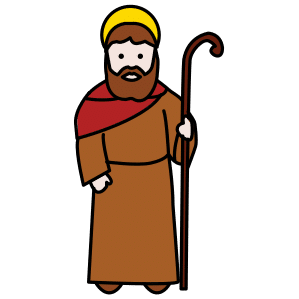

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

partirono


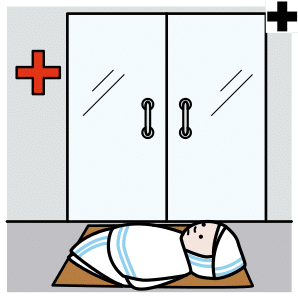

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

per


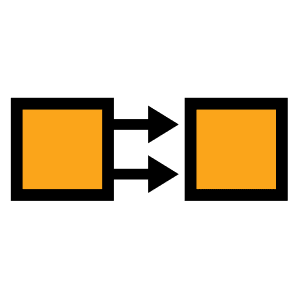

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

betlemme


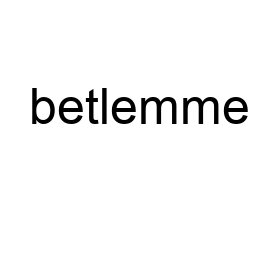

<IPython.core.display.Javascript object>

,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

molte


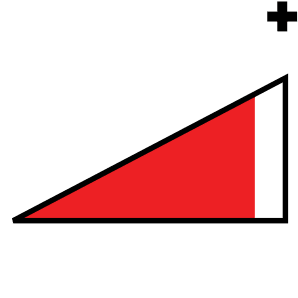

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

persone


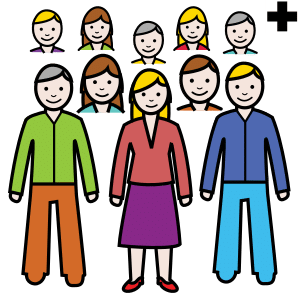

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

andavano


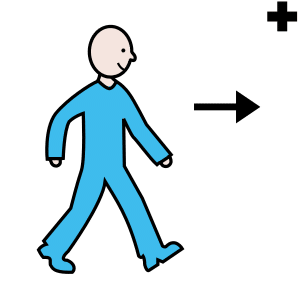

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

a


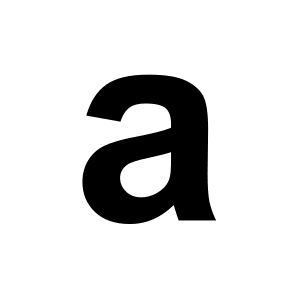

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

betlemme


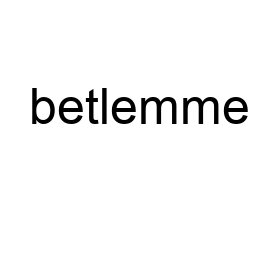

<IPython.core.display.Javascript object>

,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Maria


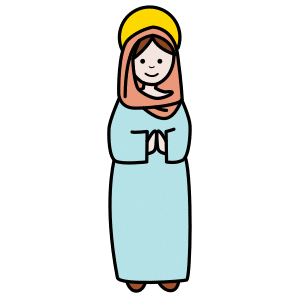

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

era


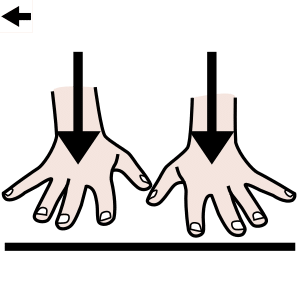

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

molto


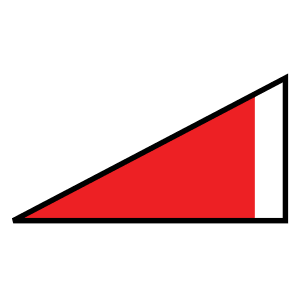

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

stanca


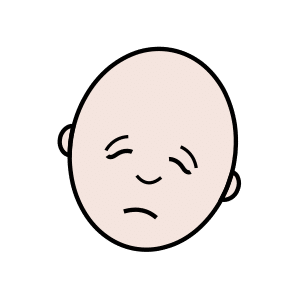

<IPython.core.display.Javascript object>

,,,,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Maria


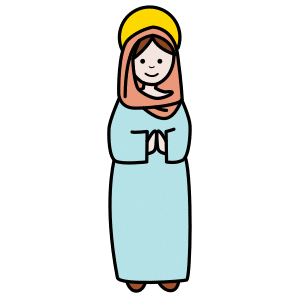

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e


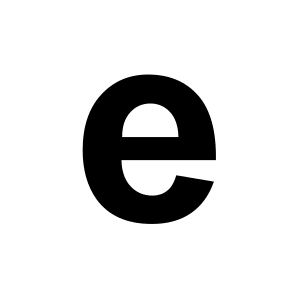

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Giuseppe


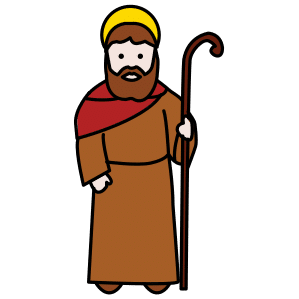

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cercavano


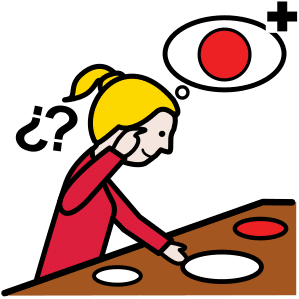

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

una


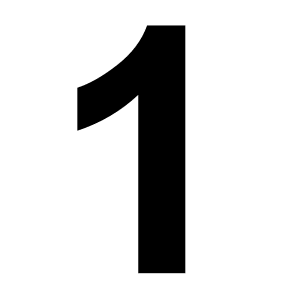

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

casa


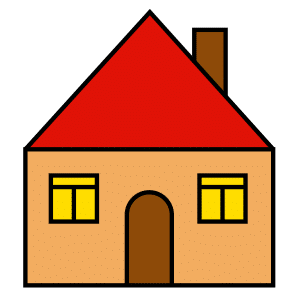

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

per


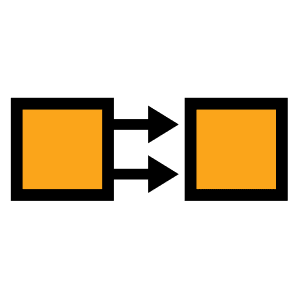

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dormire


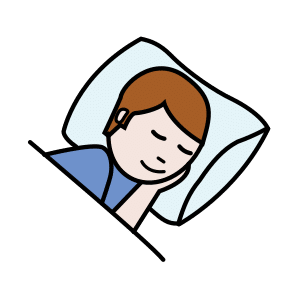

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ma


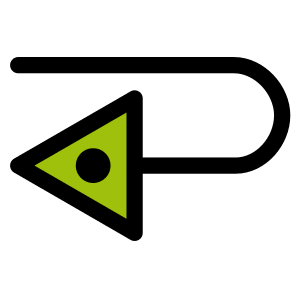

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tutti


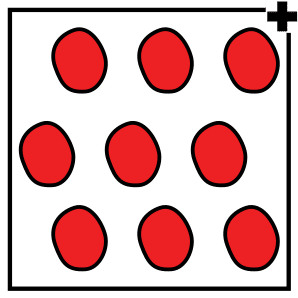

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

li


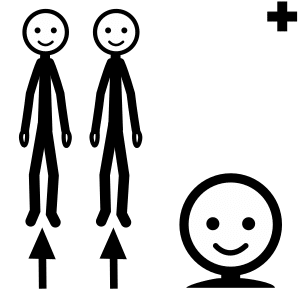

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mandavano


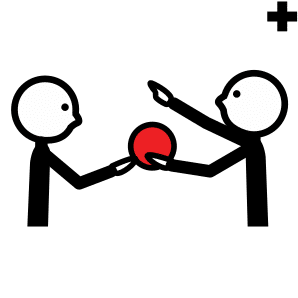

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

andare via


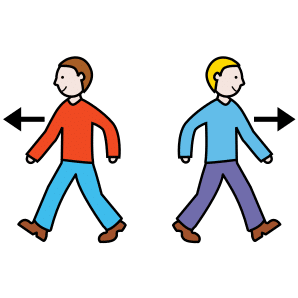

<IPython.core.display.Javascript object>

,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Maria


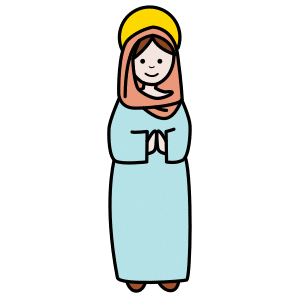

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e


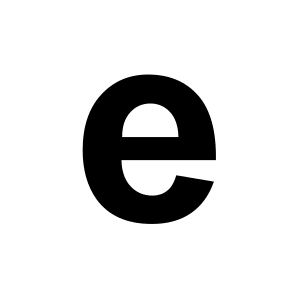

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Giuseppe


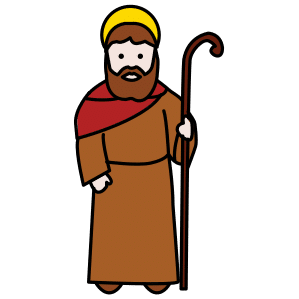

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

andarono


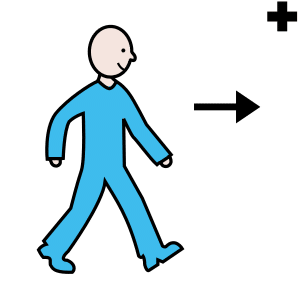

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

a


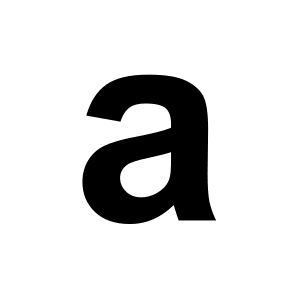

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dormire


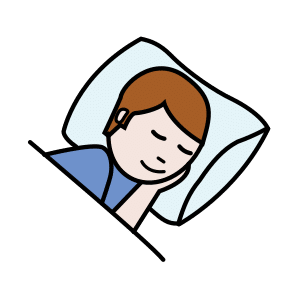

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

in


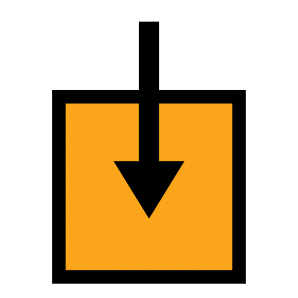

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

una


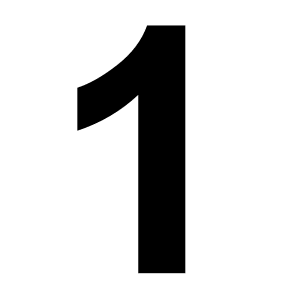

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

stalla


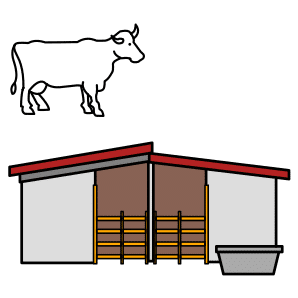

<IPython.core.display.Javascript object>

,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

durante


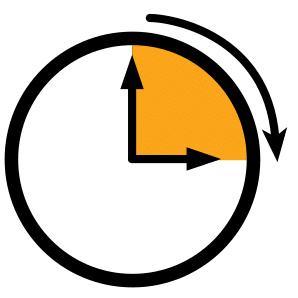

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

la


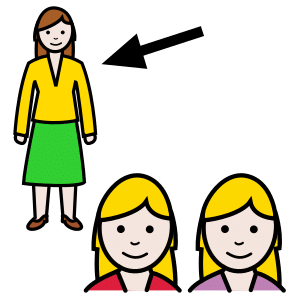

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

notte


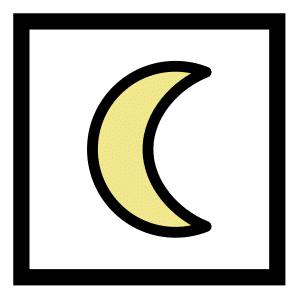

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Maria


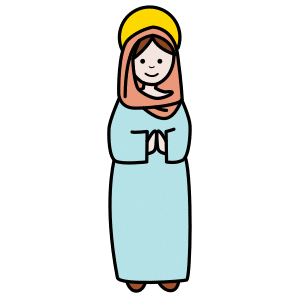

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

partorì


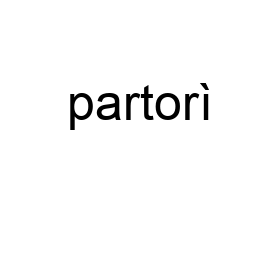

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Gesù


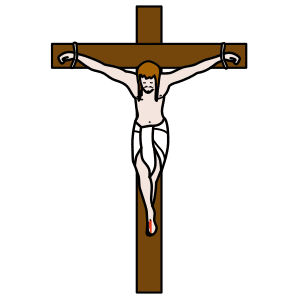

<IPython.core.display.Javascript object>

,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

un


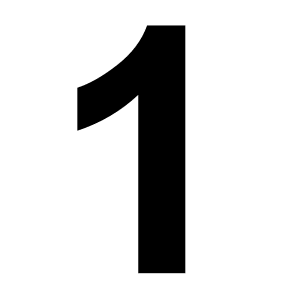

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

angelo


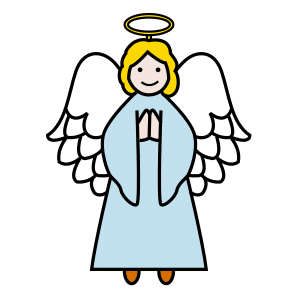

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

annunciò


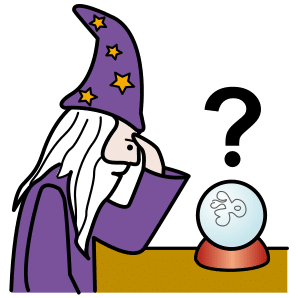

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ai


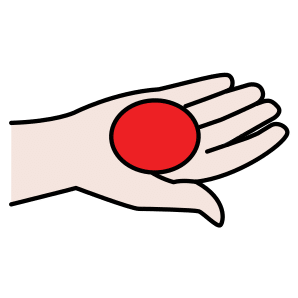

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

pastori


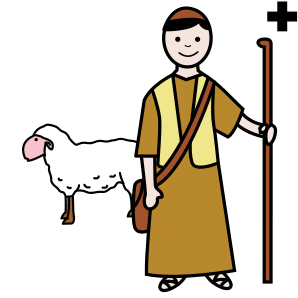

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

che


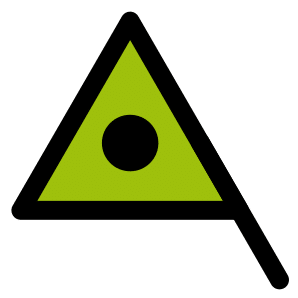

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

era


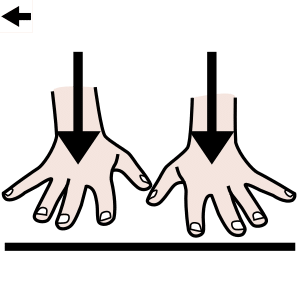

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nato


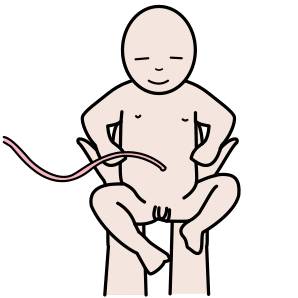

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Gesù


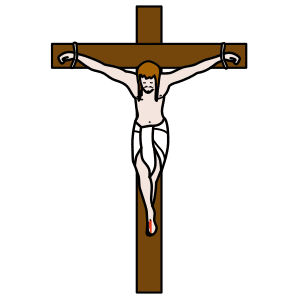

<IPython.core.display.Javascript object>

,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

i


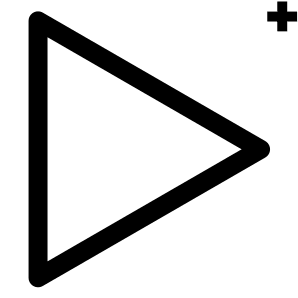

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

pastori


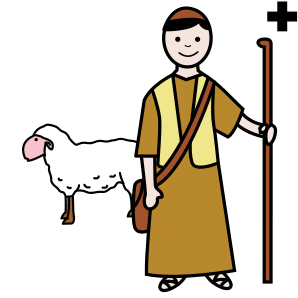

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

partirono


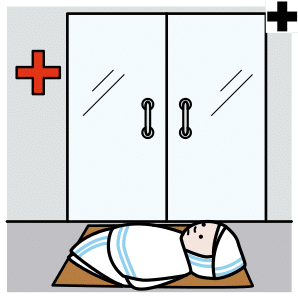

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

per


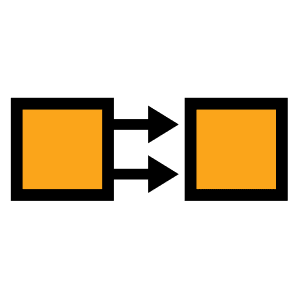

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

vedere


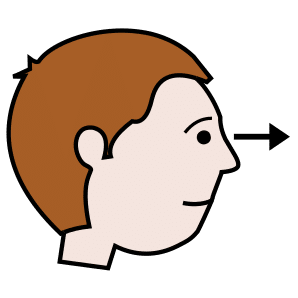

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Gesù


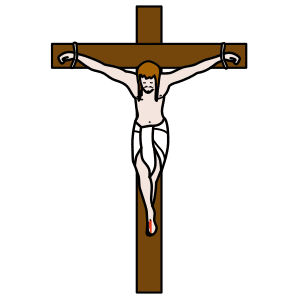

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e


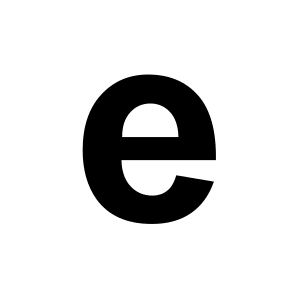

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

portargli


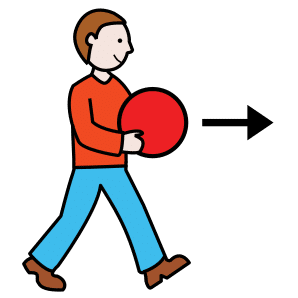

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done


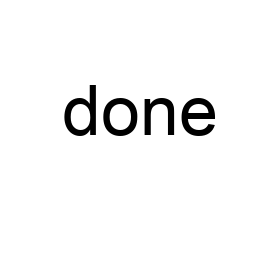

<IPython.core.display.Javascript object>

,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

quella


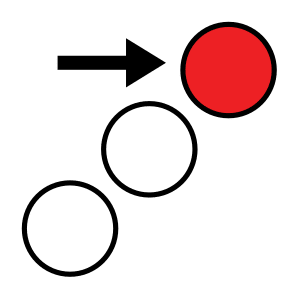

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

notte


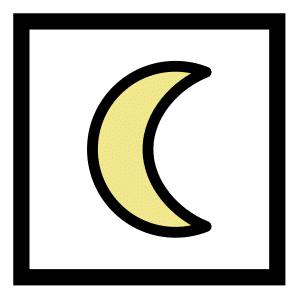

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

una


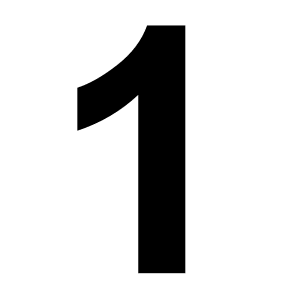

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

stella


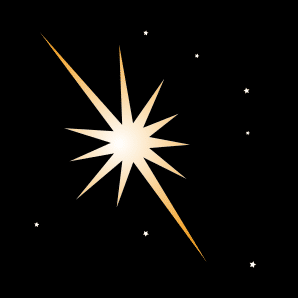

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cometa


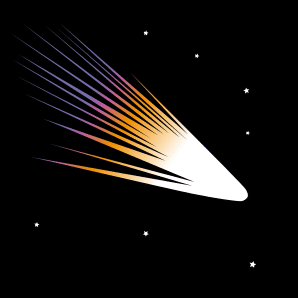

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

attraversò


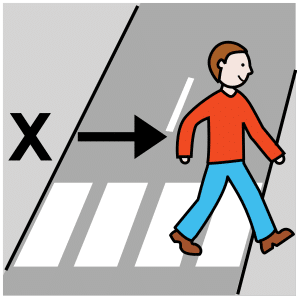

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

il


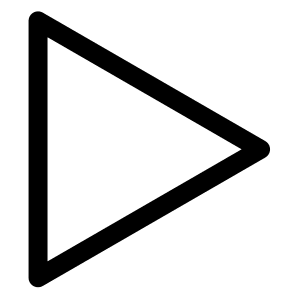

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cielo


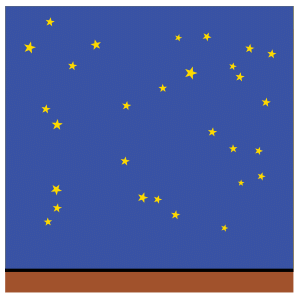

<IPython.core.display.Javascript object>

,,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tre


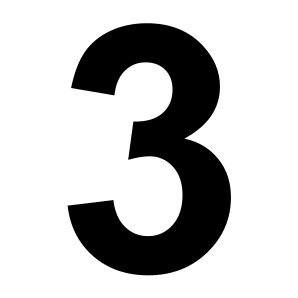

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

re


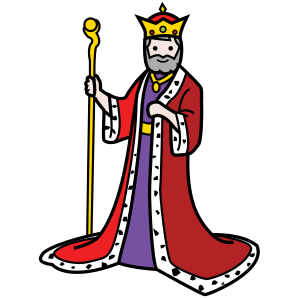

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

magi


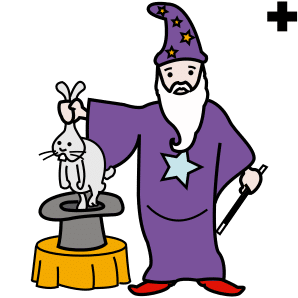

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

videro


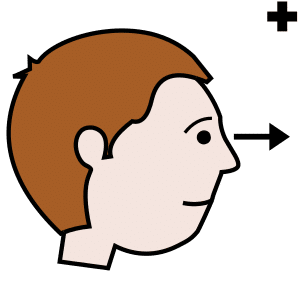

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

la


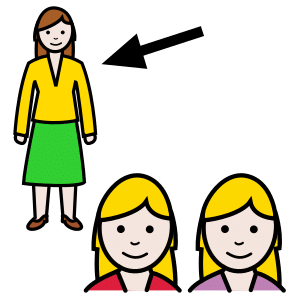

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

stella


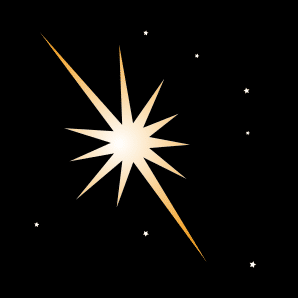

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cometa


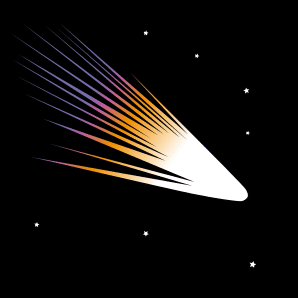

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e


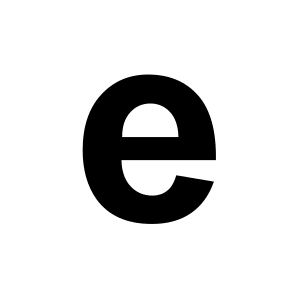

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

partirono


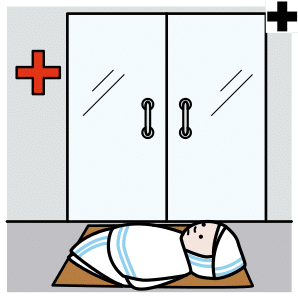

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

per


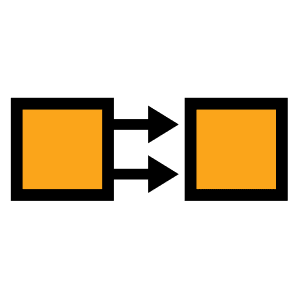

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

betlemme


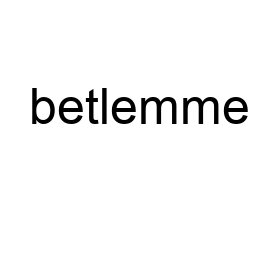

<IPython.core.display.Javascript object>

,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

i


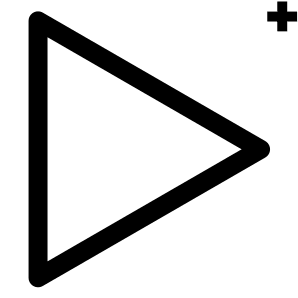

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

re


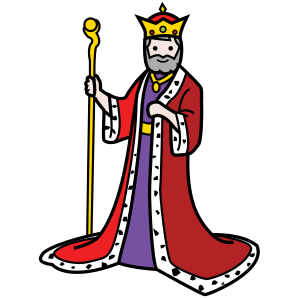

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

magi


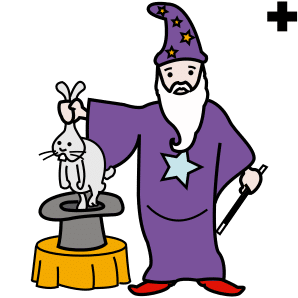

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

portarono


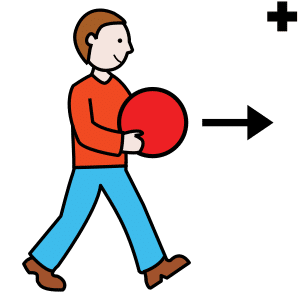

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

altri


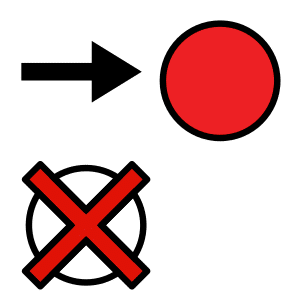

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done


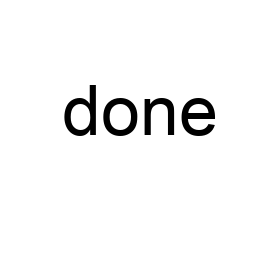

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

a


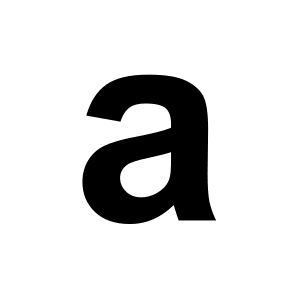

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Gesù


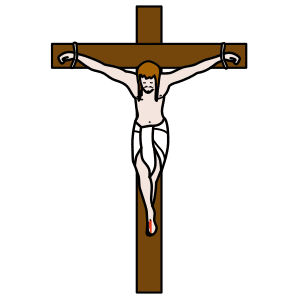

<IPython.core.display.Javascript object>

,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

a


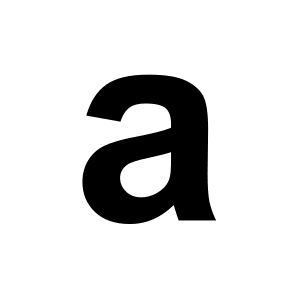

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Natale


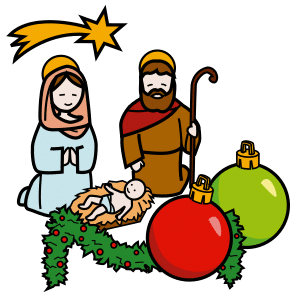

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

noi


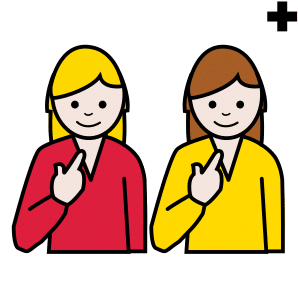

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

decoriamo


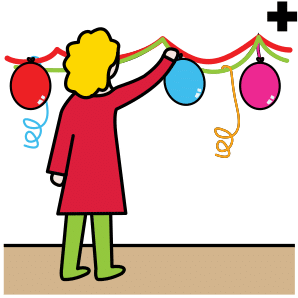

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

l'


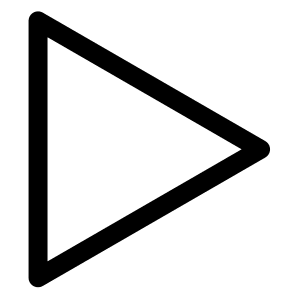

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

albero


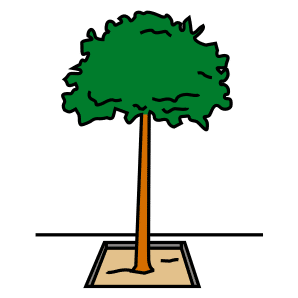

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e


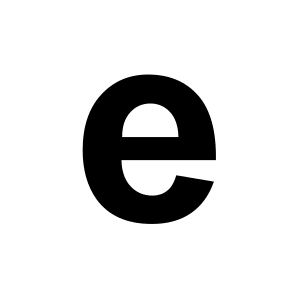

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

facciamo


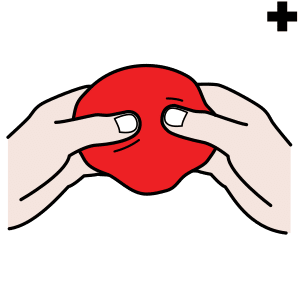

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

il


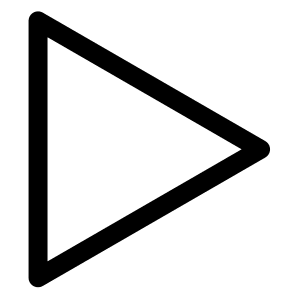

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

presepe


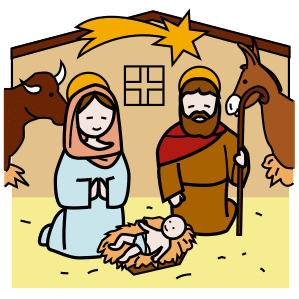

<IPython.core.display.Javascript object>

,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

l'


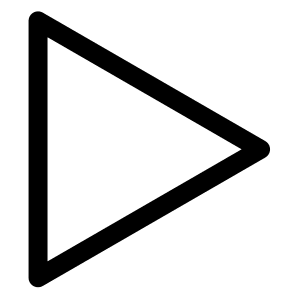

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

amicizia


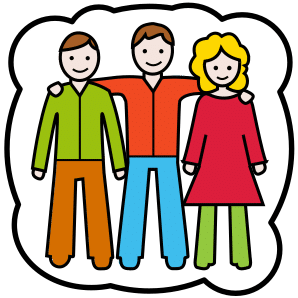

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

è


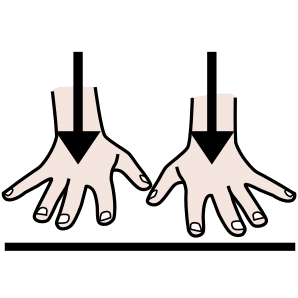

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

il


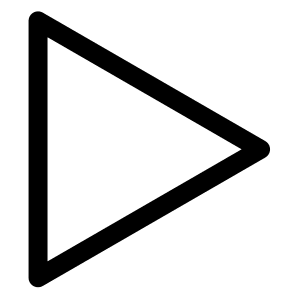

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dono


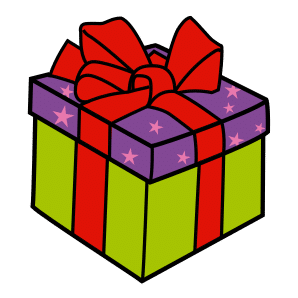

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

più


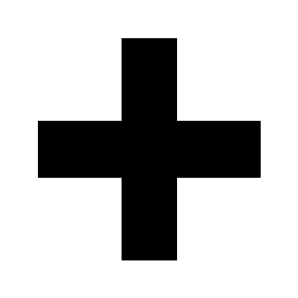

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

bello


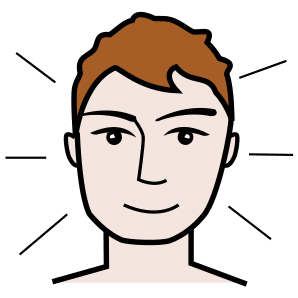

<IPython.core.display.Javascript object>

,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

buon


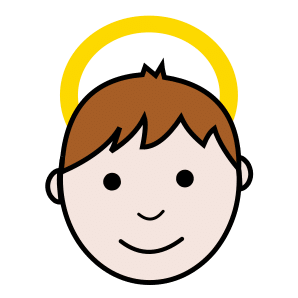

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Natale


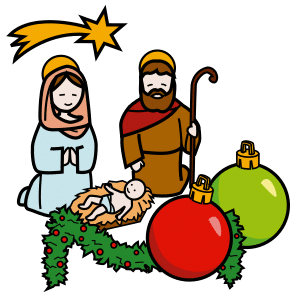

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

a


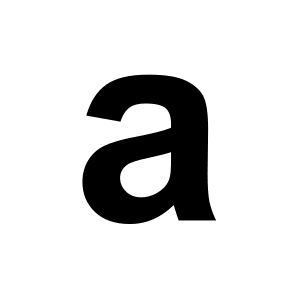

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tutti


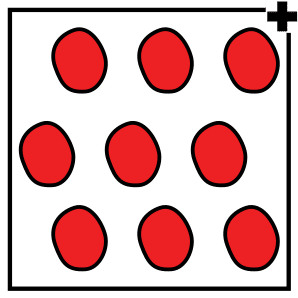

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

!


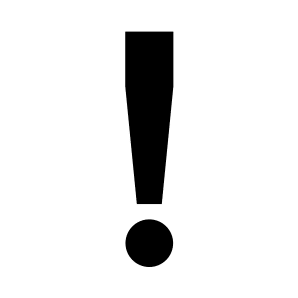

<IPython.core.display.Javascript object>

In [24]:
from google.colab import widgets
from IPython.display import Image, display
import glob
fileList = glob.glob('/content/drive/MyDrive/immagini/*.png')
for filePath in fileList:
  os.remove(filePath)
imageName=0
picsList=[]
words_for_images_list=[]
sentences_book = pd.read_csv('/content/drive/MyDrive/sentences_book.csv')
sentences=[]
for i in range(len(sentences_book)):
  sentences.append(sentences_book["Column1"][i])


for i in sentences:
  translate(i)
print(words_for_images_list)
print(picsList)
index=0
for k in range(len(words_for_images_list)):
  grid=widgets.Grid(1,len(words_for_images_list[k]),header_row=True,header_column=True)
  j=0
  for word in words_for_images_list[k]:
    with grid.output_to(0, j):
        print(word)
        display(Image(path_CAA_pictograms+str(index)+'.png',width=70, height=70))
        index+=1
        j+=1

